In [ ]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset

%load_ext autoreload
%autoreload 2

In [ ]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

In [ ]:
args = {
    'processor':         'GENConv',
    'head':              'classification',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(9, 7, train_num, rng, **er_config),
        *ig.sample_instances(9, 7, train_num, rng, **ba_config),
        *ig.sample_instances(9, 7, train_num, rng, **geom_config),
    ]

test_instances = [
        *ig.sample_instances(9, 7, test_num, rng, **er_config),
        *ig.sample_instances(9, 7, test_num, rng, **ba_config),
        *ig.sample_instances(9, 7, test_num, rng, **geom_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

In [ ]:
# save(GNN, args, 'GNN3')

In [ ]:
GNN, args = load('GNN1', device)

In [ ]:
from gnn_library.OBM_greedy import OBM_Greedy
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy

thresholds = np.linspace(0, 1, 101)
thresholded_greedy_models = [(threshold, OBM_Threshold_Greedy(threshold)) for threshold in thresholds]

seed = np.random.randint(0, 500000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

greedy_ratios = {}
for threshold, model in thresholded_greedy_models: 
    ratio = evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=eval_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
pp_output(ratios2, _, show_log=False)
print(greedy_ratios)

In [ ]:
max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(max_threshold, greedy_ratios[max_threshold])

# Pivot to feature-generated graphs

In [ ]:
import pickle
def get_location_info(city):
	intersections = ox.graph_from_place(city, network_type="drive").nodes
	with open(f"data/OSMNX_{city}_travel_times.pickle", "rb") as handle:
		drive_times = pickle.load(handle)

	return {
		'intersections': intersections, 
		'drive_times': drive_times,
		'city': city
	}

In [ ]:
piedmont = get_location_info("Piedmont, California, USA")
founex = get_location_info("Founex, Switzerland")
carmel = get_location_info("Carmel, Indiana, USA")
geneva = get_location_info("Geneva, Switzerland")

In [ ]:
#TODO PUT BACK TO REGRESSION
#!!!!!!!!!!!!!!!!!!!!!!!!!!!
args = {
    'processor':         'TEST2',
    'head':              'regression',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 0.75,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
osmnx_config = {
    'graph_type': 'OSMNX',
    'location_info': piedmont
}
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(10, 6, train_num, rng, **er_config),
        *ig.sample_instances(10, 6, train_num, rng, **ba_config),
        *ig.sample_instances(10, 6, train_num, rng, **feat_config),
        *ig.sample_instances(10, 6, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(10, 6, test_num, rng, **er_config),
        *ig.sample_instances(10, 6, test_num, rng, **ba_config),
        *ig.sample_instances(10, 6, train_num, rng, **feat_config),
        *ig.sample_instances(10, 6, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [ ]:
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy
from tqdm import tqdm
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
thresholds = np.linspace(0, 1, 2) # TODO remove
#TODO max value in threshold should be max value observable in graphs (is not the case for osmnx graphs for the moment)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

osmnx_config1 = {
    'graph_type': 'OSMNX',
    'location_graph': piedmont['location_graph']
}
osmnx_config2 = {
    'graph_type': 'OSMNX',
    'location_graph': geneva['location_graph']
}
osmnx_config3 = {
    'graph_type': 'OSMNX',
    'location_graph': carmel['location_graph']
}

train_num = 10
train_instances = [
        *ig.sample_instances(9, 7, train_num, rng, **osmnx_config1),
        *ig.sample_instances(9, 7, train_num, rng, **osmnx_config2),
        *ig.sample_instances(9, 7, train_num, rng, **osmnx_config3),
]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

In [ ]:
print(greedy_ratios)

## Evaluation

In [ ]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 25
eval_instances = [
        *ig.sample_instances(m, n, eval_num, rng, **er_config),
        *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
]

ratios, _ = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=5,
    baselines=['greedy', 'lp_rounding']
)


# ratios2 = ev.evaluate_model(
#     meta_model=None,
#     meta_model_type=None,
#     base_models=[THRESHOLD_MODEL],
#     instances=eval_instances,
#     batch_size=50,
#     rng=rng,
#     num_realizations=5
# )

pp_output(ratios)
#print(f"Thresholded greedy: {np.mean(ratios2[0]).round(4)}")


In [ ]:
num_trials = 10
node_configs = [(x, 16) for x in np.arange(4, 40, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    # {
    #     'graph_type': 'ER',
    #     'p': 0.75,
    #     'weighted': False
    # },
    # {
    #     'graph_type': 'BA',
    #     'ba_param': 4,
    #     'weighted': False
    # },
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.9,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.95,
    #     'weighted': True
    # },

    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config['location_info']['city'], node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

In [ ]:
num_trials = 10
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 




graph_configs = [
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.5
    # },
    {
        'graph_type': 'OSMNX',
        'location_info': piedmont
    },
    {
        'graph_type': 'OSMNX',
        'location_info': carmel
    },
    {
        'graph_type': 'OSMNX',
        'location_info': geneva
    },
    {
        'graph_type': 'OSMNX',
        'location_info': founex
    },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.75,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.9,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.95,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.99
    # }
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['location_info']['city']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config['location_info']['city'])
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )
        thresholded_greedy_ratios = [0]

        # thresholded_greedy_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
        #     meta_model=None,
        #     meta_model_type=None,
        #     base_models=[THRESHOLD_MODEL],
        #     instances=instances,
        #     batch_size=batch_size,
        #     rng=rng,
        #     num_realizations=5
        # )

        data[graph_config['location_info']['city']].append(np.array(
            [
                ratios["learned"],
                #thresholded_greedy_ratios,
                ratios["greedy"],
                ratios["lp_rounding"]
            ]
        ))

In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
print(ratios)
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        #thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())
        

    title = f"OSMNX_discard_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    #plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    # plt.savefig(f"data/{title}.png")
    plt.show()


## Graph transferability

In [25]:
num_trials = 40
node_configs = [(x, x) for x in np.arange(4, 40, 4)]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]


graph_configs = [
    {
    'graph_type': 'FEAT',
    'q': 0.75,
    'weighted': True
    },
]

sizes = [x for (x,_) in node_configs]
print(sizes)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)

        cr_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5,
            baselines=['greedy', 'lp_rounding']
        )

        thresholded_greedy_ratios = [0]

        data[graph_config['q']].append(cr_ratios)

[4, 8, 12, 16, 20, 24, 28, 32, 36]
(4, 4) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
Set parameter TokenServer to value "soal-nas.stanford.edu"
(8, 8) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(12, 12) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(16, 16) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(20, 20) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(24, 24) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(28, 28) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(32, 32) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}
(36, 36) {'graph_type': 'FEAT', 'q': 0.75, 'weighted': True}


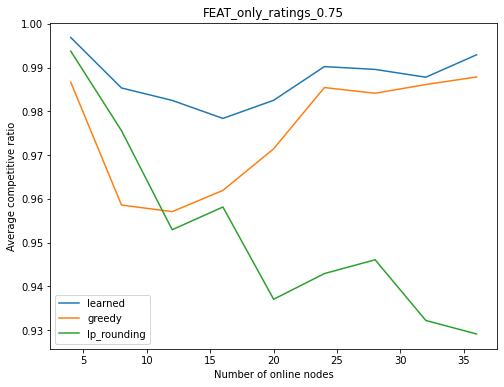

In [26]:
import matplotlib.pyplot as plt

sizes = [x for (x,_) in node_configs]

aggregated_ratios = {}
for q, comp_ratios in data.items():
    for trial_ratios in comp_ratios:
        for model, ratio_values in trial_ratios.items():
            current_ratios = aggregated_ratios.get(model, [])
            current_ratios.append(np.array(ratio_values).mean())
            aggregated_ratios[model] = current_ratios

fig = plt.figure(figsize=(8,6))
for model, ratios in aggregated_ratios.items():
    plt.plot(sizes, ratios, label=model)

title = f"FEAT_only_ratings_{q}"
plt.title(title)
plt.xlabel('Number of online nodes')
plt.ylabel('Average competitive ratio')
plt.legend()
# plt.savefig(f"data/{title}.png")
plt.show()
